# 导入所需包

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 导入模型
from mnist import MnistClassifier

# 设置训练超参数

In [2]:
BATCH_SIZE = 128
EPOCHS = 50
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 导入数据并检查

In [3]:
trainsets = datasets.MNIST(root='./data', train=True, download=False, transform=transforms.ToTensor())
testsets = datasets.MNIST(root='./data', train=False, download=False, transform=transforms.ToTensor())

In [4]:
print(trainsets.data.shape, trainsets.data.min(), trainsets.data.max())
print(testsets.data.shape, testsets.data.min(), testsets.data.max())

torch.Size([60000, 28, 28]) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
torch.Size([10000, 28, 28]) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


In [5]:
print(trainsets.data.numpy().astype(np.float).mean(), trainsets.data.numpy().astype(np.float).std())
print(testsets.data.numpy().astype(np.float).mean(), testsets.data.numpy().astype(np.float).std())

/home/xd2/anaconda3/envs/DeepLearningLab/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


33.318421449829934 78.56748998339798
33.791224489795916 79.17246322228644


/home/xd2/anaconda3/envs/DeepLearningLab/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [6]:
train_loader = torch.utils.data.DataLoader(dataset=trainsets, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testsets, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
sample_image, sample_label = next(iter(train_loader))
print(sample_image.data.shape, sample_image.data.min(), sample_image.max())
print(sample_image.data.mean(), sample_image.data.std())

torch.Size([128, 1, 28, 28]) tensor(0.) tensor(1.)
tensor(0.1325) tensor(0.3104)


# 构建分类模型

In [8]:
model = MnistClassifier()

# 训练过程设置

In [9]:
criterion = nn.CrossEntropyLoss()

In [10]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [11]:
def test(model, test_loader, criterion):
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(DEVICE).eval()
    correct = 0.0
    total = 0.0
    accuracy = 0.0
    labels_total = torch.tensor([], dtype=torch.long)
    predicted_total = torch.tensor([], dtype=torch.long)
    loss_total = 0.0
    
    with torch.no_grad():
    
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            output = model(images)
            predict = torch.max(output.data, axis=1)[1]
            total += labels.size(0)
            correct += (predict.cpu() == labels.cpu()).sum()
            
            labels_total = torch.cat((labels_total, labels.cpu()))
            predicted_total = torch.cat((predicted_total, predict.cpu()))
            
            #Loss
            logps = model.forward(images)
            batch_loss = criterion(logps, labels)
            loss_total += batch_loss.item()
            
        accuracy = correct.item() / total * 100
        loss = loss_total / len(test_loader)
    
    return labels_total, predicted_total, accuracy, loss

In [12]:
test(model, test_loader, criterion)

(tensor([7, 2, 1,  ..., 4, 5, 6]),
 tensor([0, 6, 6,  ..., 6, 6, 6]),
 13.26,
 2.308510707903512)

In [13]:
def train(model, train_loader, test_loader, criterion, optimizer, EPOCHS):
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_list = []
    accuracy_list = []
    iteration_list = []
    best_accuracy = 0.0
    
    test_acc_list = []
    test_loss_list = []    
    
    iter = 0
    for epoch in range(EPOCHS):
        print("--------------- Train Epoch : {} ---------------".format(epoch+1))
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            model = model.to(DEVICE).train()
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            iter += 1
            
            if iter % 200 == 0:
                accuracy = (torch.argmax(output.data, axis=1) == labels).sum() * 100. / labels.size(0)
                loss_list.append(loss.item())
                accuracy_list.append(accuracy.item())
                iteration_list.append(iter)
                
                print("Train Loop : {}, Train Loss : {}, Train Accuracy: {}".format(iter, loss.item(), accuracy))
        
        _, _, current_accuracy, current_loss = test(model, test_loader, criterion)
        test_acc_list.append(current_accuracy)
        test_loss_list.append(current_loss)
        
        print("Epoch : ", epoch+1, "Test Loss : ", current_loss, "Test Accuracy : ", current_accuracy)
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            best_model = model.cpu()
            print("Best model updates successfully!")
    
    model_dir = r'./mnist-classifier.pth'
    trainLog_dir = r'./log/TrainLog-mnist.pt'
    testLog_dir = r'./log/TestLog-mnist.pt'
    
    torch.save(best_model.state_dict(), model_dir)
    torch.save([iteration_list, accuracy_list, loss_list], trainLog_dir)
    torch.save([test_acc_list, test_loss_list], testLog_dir)
    print("Save Successful!")

In [14]:
train(model=model, train_loader=train_loader, test_loader=test_loader, criterion=criterion, optimizer=optimizer, EPOCHS=50)

--------------- Train Epoch : 1 ---------------
Train Loop : 200, Train Loss : 0.2950354814529419, Train Accuracy: 89.0625
Train Loop : 400, Train Loss : 0.22811682522296906, Train Accuracy: 92.96875
Epoch :  1 Test Loss :  0.12530892812116426 Test Accuracy :  95.94
Best model updates successfully!
--------------- Train Epoch : 2 ---------------
Train Loop : 600, Train Loss : 0.09720455855131149, Train Accuracy: 96.09375
Train Loop : 800, Train Loss : 0.13513922691345215, Train Accuracy: 96.09375
Epoch :  2 Test Loss :  0.06665550520838108 Test Accuracy :  97.77
Best model updates successfully!
--------------- Train Epoch : 3 ---------------
Train Loop : 1000, Train Loss : 0.07893194258213043, Train Accuracy: 96.09375
Train Loop : 1200, Train Loss : 0.0687430202960968, Train Accuracy: 97.65625
Train Loop : 1400, Train Loss : 0.03564415127038956, Train Accuracy: 98.4375
Epoch :  3 Test Loss :  0.053860501570058276 Test Accuracy :  98.29
Best model updates successfully!
--------------- T

In [15]:
model_dir = r'./mnist-classifier.pth'
trainLog_dir = r'./log/TrainLog-mnist.pt'
testLog_dir = r'./log/TestLog-mnist.pt'

In [16]:
testModel = MnistClassifier()
testModel.load_state_dict(torch.load(model_dir))

<All keys matched successfully>

In [17]:
test(testModel, test_loader, criterion)

(tensor([7, 2, 1,  ..., 4, 5, 6]),
 tensor([7, 2, 1,  ..., 4, 5, 6]),
 99.09,
 0.05288640868483906)

In [18]:
iteration_list, accuracy_list, loss_list = torch.load(trainLog_dir)

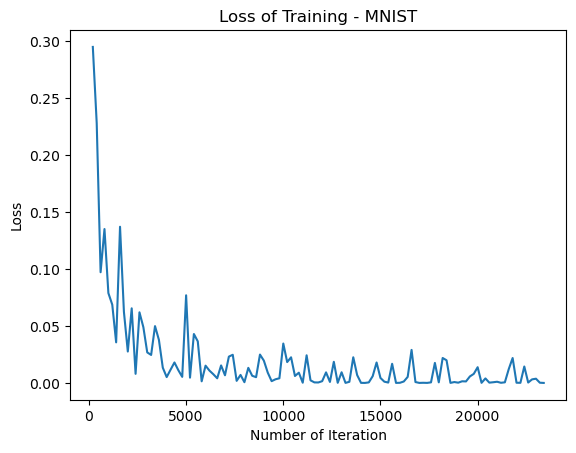

In [19]:
plt.plot(iteration_list, loss_list)
plt.xlabel('Number of Iteration')
plt.ylabel('Loss')
plt.title('Loss of Training - MNIST')
plt.show()

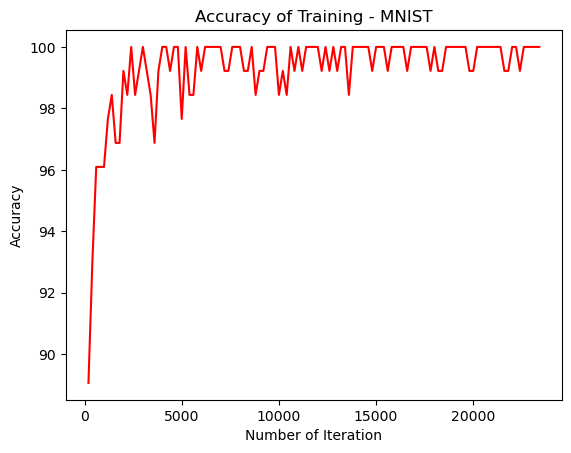

In [20]:
plt.plot(iteration_list, accuracy_list, color='r')
plt.xlabel('Number of Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy of Training - MNIST')
plt.show()

In [21]:
test_acc_list, test_loss_list = torch.load(testLog_dir)

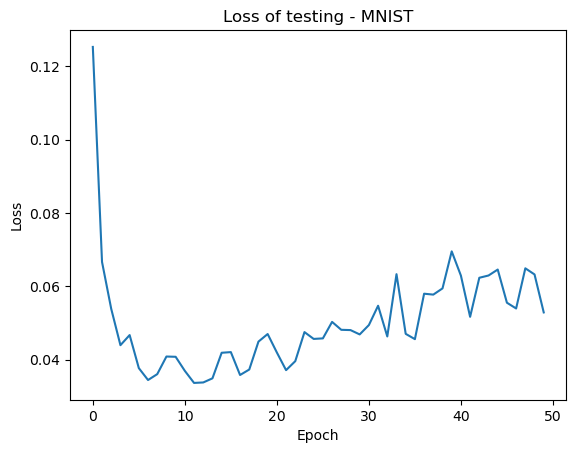

In [22]:
plt.plot(test_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss of testing - MNIST')
plt.show()

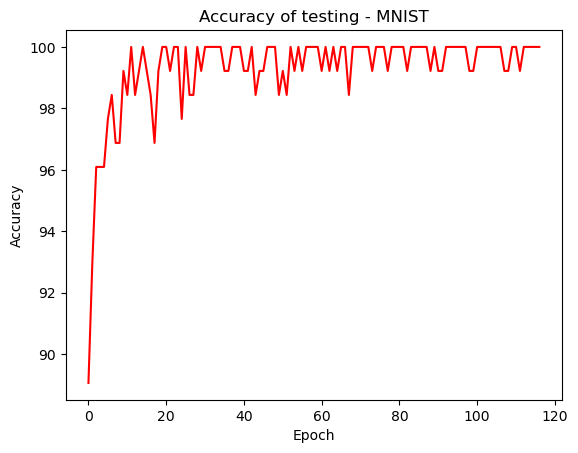

In [23]:
plt.plot(accuracy_list, color='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy of testing - MNIST')
plt.show()